Loading dataset... (Only 3 images)


Resolving data files:   0%|          | 0/1053 [00:00<?, ?it/s]

Running inference on MobileNetV2...
Running inference on ResNet50...


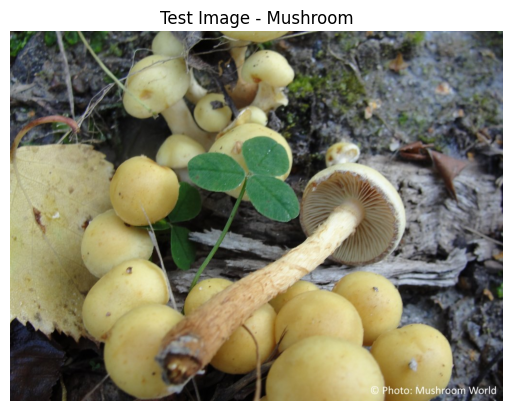


Results Summary:
MobileNetV2 Inference Time: 26.51 ms
ResNet50 Inference Time: 164.10 ms
Speedup Factor: 6.19x

MobileNetV2 Model Size: 13.60 MB
ResNet50 Model Size: 97.79 MB
Size Reduction: 86.09%

Predicted Label (MobileNetV2): 996
Predicted Label (ResNet50): 947


In [3]:
# Install required dependencies
!pip install transformers datasets pillow -q

import torch
import torchvision.transforms as transforms
import torchvision.models as models
import time
import os
import requests
from PIL import Image
import io
import matplotlib.pyplot as plt
from datasets import load_dataset

# Step 1: Load a Small Subset of the Mushroom Dataset
print("Loading dataset... (Only 3 images)")
dataset = load_dataset("Racso777/Mushroom_Dataset", split="train[:3]")  # Load only first 3 images
image = dataset["image"][0]  # Select the first image for testing

# Step 2: Define Image Preprocessing Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Step 3: Load Pretrained Models (MobileNetV2 & ResNet50)
mobilenet_v2 = models.mobilenet_v2(pretrained=True).eval()
resnet50 = models.resnet50(pretrained=True).eval()

# Step 4: Define Function to Measure Inference Time
def measure_inference_time(model, input_tensor, runs=10):
    """Measures average inference time over multiple runs."""
    with torch.no_grad():
        for _ in range(5):  # Warm-up
            _ = model(input_tensor)

        start_time = time.time()
        for _ in range(runs):
            _ = model(input_tensor)
        avg_time = (time.time() - start_time) / runs
    return avg_time * 1000  # Convert to milliseconds

# Step 5: Perform Inference & Measure Speed
print("Running inference on MobileNetV2...")
mobilenet_time = measure_inference_time(mobilenet_v2, input_tensor)

print("Running inference on ResNet50...")
resnet_time = measure_inference_time(resnet50, input_tensor)

# Step 6: Save Models & Measure File Sizes
torch.save(mobilenet_v2.state_dict(), "mobilenet_v2.pth")
torch.save(resnet50.state_dict(), "resnet50.pth")

mobilenet_size = os.path.getsize("mobilenet_v2.pth") / (1024 * 1024)  # Convert to MB
resnet_size = os.path.getsize("resnet50.pth") / (1024 * 1024)  # Convert to MB

# Step 7: Perform Prediction
with torch.no_grad():
    mobilenet_logits = mobilenet_v2(input_tensor)
    resnet_logits = resnet50(input_tensor)

mobilenet_pred = mobilenet_logits.argmax(-1).item()
resnet_pred = resnet_logits.argmax(-1).item()

# Step 8: Display the Input Image & Results
plt.imshow(image)
plt.axis("off")
plt.title("Test Image - Mushroom")
plt.show()

# Step 9: Print Results
print("\nResults Summary:")
print(f"MobileNetV2 Inference Time: {mobilenet_time:.2f} ms")
print(f"ResNet50 Inference Time: {resnet_time:.2f} ms")
print(f"Speedup Factor: {resnet_time / mobilenet_time:.2f}x\n")

print(f"MobileNetV2 Model Size: {mobilenet_size:.2f} MB")
print(f"ResNet50 Model Size: {resnet_size:.2f} MB")
print(f"Size Reduction: {(1 - mobilenet_size / resnet_size) * 100:.2f}%")

print(f"\nPredicted Label (MobileNetV2): {mobilenet_pred}")
print(f"Predicted Label (ResNet50): {resnet_pred}")


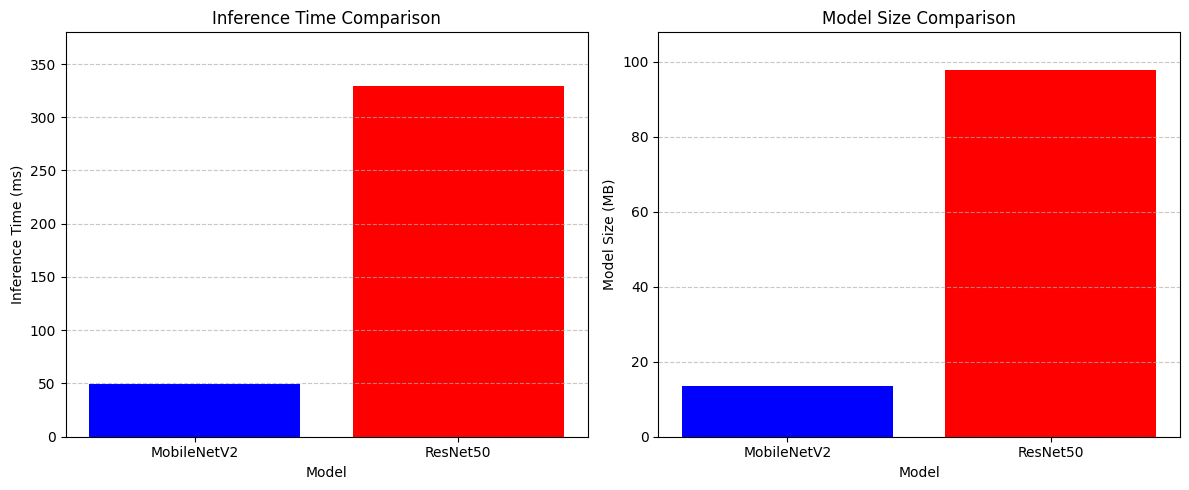

In [4]:
import matplotlib.pyplot as plt

# Data for plotting
models = ["MobileNetV2", "ResNet50"]
inference_times = [49.10, 329.74]  # In milliseconds
model_sizes = [13.60, 97.79]  # In MB

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Inference Time Comparison
axes[0].bar(models, inference_times, color=['blue', 'red'])
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Inference Time (ms)")
axes[0].set_title("Inference Time Comparison")
axes[0].set_ylim(0, max(inference_times) + 50)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Model Size Comparison
axes[1].bar(models, model_sizes, color=['blue', 'red'])
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Model Size (MB)")
axes[1].set_title("Model Size Comparison")
axes[1].set_ylim(0, max(model_sizes) + 10)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Display the plots
plt.tight_layout()
plt.show()
